In [1]:
import sys
sys.path.append(r'../dotNet/libs')

import clr
clr.AddReference("Microsoft.ML.Probabilistic")
clr.AddReference("Microsoft.ML.Probabilistic.Compiler")
clr.AddReference("Microsoft.ML.Probabilistic.Learners")

from System import Array, Double, Type
from utils import plot_graph

In [2]:
from Microsoft.ML.Probabilistic.Models import Variable, VariableArray, Range, InferenceEngine
from Microsoft.ML.Probabilistic.Algorithms import VariationalMessagePassing
from Microsoft.ML.Probabilistic.Distributions import Gaussian, Gamma

In [3]:
# remove all previously generated graph files
!rm -f *.svg *.gv

### Example 1: coin toss

This is the implementation of https://dotnet.github.io/infer/userguide/a%20simple%20example.html

In [4]:
firstCoin = Variable.Bernoulli(Double(0.5)).Named('coin 1')
secondCoin = Variable.Bernoulli(Double(0.5)).Named('coin 2')
bothHeads = firstCoin.op_BitwiseAnd(firstCoin, secondCoin).Named('both heads')

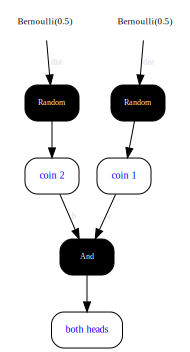

In [5]:
engine = InferenceEngine()
engine.ModelName = 'coin_toss'
engine.ShowFactorGraph = True

marginal = engine.Infer(bothHeads)
plot_graph(engine.ModelName)

In [6]:
# This should give 'Bernoulli(0.25)' since probability
# that a coin toss will give heads for both coins equals to 0.5 * 0.5 == 0.25
print(f'Probability distribution both coins are heads: {marginal}');

Probability distribution both coins are heads: Bernoulli(0.25)


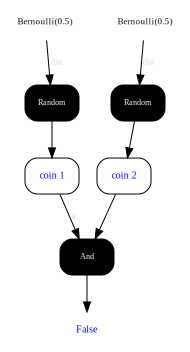

In [7]:
# Now we observe a coin toss with observed value for both heads == false
bothHeads.ObservedValue = False;  
engine.ModelName = 'coin_toss_observed'

marginal = engine.Infer(firstCoin)
plot_graph(engine.ModelName)

In [8]:
# Probability that the first coin is head == 1/3, since
# there are only 3 events possible without both coins giving heads
 print(f'Probability distribution over firstCoin: {marginal}');

Probability distribution over firstCoin: Bernoulli(0.3333)


### Example 2: Inference on Gaussian with priors

This is the implementation of https://dotnet.github.io/infer/userguide/Running%20inference.html

**Note**: as mentioned in the README, we can't call `Variable.Observed` as in the C# code. Another issue encountered is the usage of the `[]` indexer, which doesn't seem to be correctly resolved by python.net. The code below is a workaround that initializes the `VariableArray` differently.  

In [9]:
mean_point = 0.0
precision_point = 1.0
# define the priors for the mean and precision of the Gaussian
mean = Variable.GaussianFromMeanAndVariance(mean_point, 100.0).Named('mean')
precision = Variable.GammaFromShapeAndScale(precision_point, 1.0).Named('precision')

# define observed values as drawn from a Gaussian(mean, precision)
i = Range(4)
data = Variable.Array[Double](i).Named('observations')
data.set_Item(i, Variable.GaussianFromMeanAndPrecision(mean, precision).ForEach(i))
data.set_ObservedValue(Array[Double]([11.0, 5.0, 8.0, 9.0]))

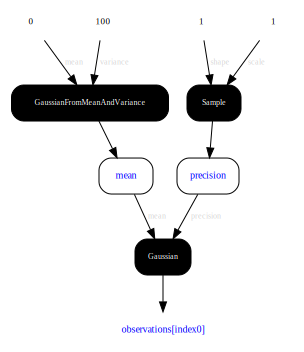

In [10]:
# run inference
engine = InferenceEngine(VariationalMessagePassing()) 
engine.ModelName = 'Gaussian_priors'
engine.ShowFactorGraph = True
# get the posterior distributions
posteriorMean = engine.Infer[Gaussian](mean)  
posteriorPrecision = engine.Infer[Gamma](precision)  
plot_graph(engine.ModelName)

In [11]:
# This should show the following output:
# mean = Gaussian(8.165, 1.026)
# precision = Gamma(3, 0.08038)[mean=0.2411]
print(f'mean = {posteriorMean}')  
print(f'precision = {posteriorPrecision}')

mean = Gaussian(8.165, 1.026)
precision = Gamma(3, 0.08038)[mean=0.2411]


If we sample observations from the mean prior Gaussian with increasing number of samples, we should see the posterior marginals converge to the distributions centered around the mean values with decreasing variance.

In [12]:
def observations_Gaussian(mean, precision,
                          mean_dist, precision_dist, nb_samples):
    i = Range(nb_samples)
    data = Variable.Array[Double](i)
    data.set_Item(i, 
        Variable.GaussianFromMeanAndPrecision(mean_dist, precision_dist).ForEach(i))
    data.set_ObservedValue(Array[Double](
        [Gaussian.Sample(mean, precision) for _ in range(nb_samples)]))
    
    return data

In [13]:
engine = InferenceEngine(VariationalMessagePassing()) 

for count in range(15):
    nb_samples = 5 * 2**count 
    
    # reset the priors
    mean = Variable.GaussianFromMeanAndVariance(mean_point, 100.0)
    precision = Variable.GammaFromShapeAndScale(precision_point, 1.0)
    
    data = observations_Gaussian(mean_point, precision_point,
                                 mean, precision, nb_samples)

    print(f'number of samples: {nb_samples}')
    print(f'mean = {engine.Infer[Gaussian](mean)}')  
    print(f'precision = {engine.Infer[Gamma](precision)}')

number of samples: 5
mean = Gaussian(-0.1797, 0.3569)
precision = Gamma(3.5, 0.1595)[mean=0.5584]
number of samples: 10
mean = Gaussian(-0.03113, 0.07951)
precision = Gamma(6, 0.2095)[mean=1.257]
number of samples: 20
mean = Gaussian(0.2354, 0.06159)
precision = Gamma(11, 0.07375)[mean=0.8113]
number of samples: 40
mean = Gaussian(-0.1366, 0.01641)
precision = Gamma(21, 0.07255)[mean=1.524]
number of samples: 80
mean = Gaussian(0.0803, 0.01161)
precision = Gamma(41, 0.02626)[mean=1.077]
number of samples: 160
mean = Gaussian(-0.02961, 0.007843)
precision = Gamma(81, 0.009838)[mean=0.7968]
number of samples: 320
mean = Gaussian(0.09628, 0.003201)
precision = Gamma(161, 0.006064)[mean=0.9763]
number of samples: 640
mean = Gaussian(-0.05438, 0.001601)
precision = Gamma(321, 0.003041)[mean=0.9762]
number of samples: 1280
mean = Gaussian(-0.009661, 0.0007904)
precision = Gamma(641, 0.001542)[mean=0.9885]
number of samples: 2560
mean = Gaussian(0.001912, 0.00037)
precision = Gamma(1281, 0.00

If we sample observations from a Gaussian with different parameters than the mean values of the priors, the posterior marginals will now converge to distributions that are centered around different values.

In [14]:
for count in range(15):
    nb_samples = 5 * 2**count 
    
    # reset the priors
    mean = Variable.GaussianFromMeanAndVariance(mean_point, 100.0)
    precision = Variable.GammaFromShapeAndScale(precision_point, 1.0)
    
    data = observations_Gaussian(-2.0, 4.0,
                                 mean, precision, nb_samples)

    print(f'number of samples: {nb_samples}')
    print(f'mean = {engine.Infer[Gaussian](mean)}')  
    print(f'precision = {engine.Infer[Gamma](precision)}')

number of samples: 5
mean = Gaussian(-2.148, 0.08028)
precision = Gamma(3.5, 0.7112)[mean=2.489]
number of samples: 10
mean = Gaussian(-2.087, 0.02399)
precision = Gamma(6, 0.6947)[mean=4.168]
number of samples: 20
mean = Gaussian(-2.065, 0.01471)
precision = Gamma(11, 0.309)[mean=3.399]
number of samples: 40
mean = Gaussian(-2.081, 0.005733)
precision = Gamma(21, 0.2077)[mean=4.361]
number of samples: 80
mean = Gaussian(-1.906, 0.003774)
precision = Gamma(41, 0.08077)[mean=3.312]
number of samples: 160
mean = Gaussian(-2.03, 0.001584)
precision = Gamma(81, 0.04871)[mean=3.946]
number of samples: 320
mean = Gaussian(-1.969, 0.0008141)
precision = Gamma(161, 0.02384)[mean=3.839]
number of samples: 640
mean = Gaussian(-2.013, 0.0003896)
precision = Gamma(321, 0.01249)[mean=4.011]
number of samples: 1280
mean = Gaussian(-1.998, 0.0001833)
precision = Gamma(641, 0.006649)[mean=4.262]
number of samples: 2560
mean = Gaussian(-2.002, 9.922e-05)
precision = Gamma(1281, 0.003073)[mean=3.937]
nu